In [1]:
# On Balance Volume (OBV)
# the energy of buy/sell in the market shoule be reflected by volume
# 1. accumulating OBV: OBV_n=OBV_n-1+-V_n
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
TsingTao=pd.read_csv('TsingTao.csv',index_col='Date')
TsingTao.index=pd.to_datetime(TsingTao.index)
TsingTao.Volume=TsingTao.Volume.replace(0,np.nan)
TsingTao=TsingTao.dropna()
close=TsingTao.Close
Volume=TsingTao.Volume
# compute OBV
difClose=close.diff()
difClose[0]=0
OBV=(((difClose>=0)*2-1)*Volume).cumsum()
OBV.name='OBV'
OBV.head()

Date
2014-01-02    2592800.0
2014-01-03    1032100.0
2014-01-06    -828800.0
2014-01-07   -3763200.0
2014-01-08   -1962800.0
Name: OBV, dtype: float64

In [2]:
OBV.describe()

count    3.230000e+02
mean    -1.104009e+07
std      3.572700e+07
min     -6.132070e+07
25%     -3.602440e+07
50%     -2.539030e+07
75%      1.912695e+07
max      9.652380e+07
Name: OBV, dtype: float64

In [3]:
# 2. moving OBV
# MA of OBVs
import movingAverage as mv
smOBV=mv.smaCal(OBV,9)
smOBV.tail()

Date
2015-04-24    7.677104e+07
2015-04-27    7.864432e+07
2015-04-28    8.023227e+07
2015-04-29    8.173780e+07
2015-04-30    8.144052e+07
dtype: float64

In [4]:
# 3. modified OBV
# creating volume accumalation to replace pure volume
AdjOBV=((close-TsingTao.Low)-(TsingTao.High-close))/(TsingTao.High-TsingTao.Low)*Volume
AdjOBV.name='AdjOBV'
AdjOBV.head()
AdjOBVd=AdjOBV.cumsum()
AdjOBVd.name='AdjOBVd'
AdjOBVd.describe()

count    3.230000e+02
mean     4.242572e+07
std      4.706378e+07
min     -1.589447e+07
25%     -5.944451e+05
50%      3.387219e+07
75%      8.573505e+07
max      1.589280e+08
Name: AdjOBVd, dtype: float64

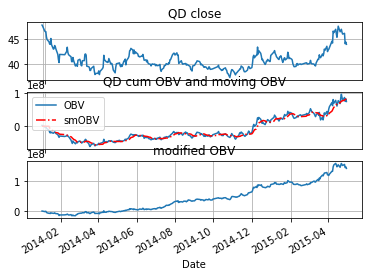

In [5]:
ax1=plt.subplot(3,1,1)
close.plot(title='QD close')
plt.xticks(close.index[1:3],(''))
plt.xlabel('')
ax2=plt.subplot(3,1,2)
OBV.plot(label='OBV',title='QD cum OBV and moving OBV')
smOBV.plot(label='smOBV',linestyle='-.',color='r')
plt.legend(loc='upper left')
plt.xticks(close.index[1:3],(''))
plt.xlabel('')
ax3=plt.subplot(3,1,3)
AdjOBVd.plot(title='modified OBV')
for ax in ax1,ax2,ax3:
    ax.grid(True)

In [6]:
# some theories behind this strategy
# 1. different perspectives from different people
# 2. gravity: must fall down
# 3. inertance of stock prices

In [7]:
# trading strategies
# OBV up: more energetic
# OBV down: may slow down
import ffn
def trade(obv,price):
    signal=(2*(obv.diff()>0)-1)[1:]
    ret=ffn.to_returns(price)[1:]
    ret.name='ret'
    tradeRet=ret*signal.shift(1)
    tradeRet.name='tradeRet'
    Returns=pd.merge(pd.DataFrame(ret),\
                     pd.DataFrame(tradeRet),\
                    left_index=True,right_index=True).dropna()
    return(Returns)

In [8]:
OBVtrade=trade(OBV,close)
OBVtrade.head()

,ret,tradeRet
Date,,
2014-01-06,-0.018701,0.018701
2014-01-07,-0.004069,0.004069
2014-01-08,0.000000,-0.000000
2014-01-09,-0.023006,-0.023006
2014-01-10,-0.011224,0.011224


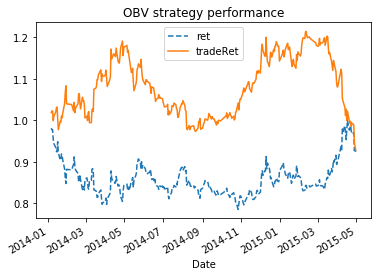

In [9]:
ret=OBVtrade.ret
tradeRet=OBVtrade.tradeRet
ret.name='BuyAndHold'
tradeRet.name='OBVTrade'
(1+ret).cumprod().plot(label='ret',linestyle='dashed')
(1+tradeRet).cumprod().plot(label='tradeRet')
plt.title('cum OBV strategy performance')
plt.legend()

In [10]:
# backtest
def backtest(ret,tradeRet):
    def performance(x):
        winpct=len(x[x>0])/len(x[x!=0])
        annRet=(1+x).cumprod()[-1]**(245/len(x))-1
        sharpe=ffn.calc_risk_return_ratio(x)
        maxDD=ffn.calc_max_drawdown((1+x).cumprod())
        perfo=pd.Series([winpct,annRet,sharpe,maxDD],index=['win rate',
                        'annualized return',\
                        'sharpe ratio','maximum drawdown'])
        return(perfo)
    BuyAndHold=performance(ret)
    OBVTrade=performance(tradeRet)
    return(pd.DataFrame({ret.name:BuyAndHold,\
    tradeRet.name:OBVTrade}))

OBVtest=backtest(ret,tradeRet)
OBVtest

,BuyAndHold,OBVTrade
win rate,0.496815,0.519108
annualized return,-0.058270,-0.055129
sharpe ratio,-0.010179,-0.009199
maximum drawdown,-0.199358,-0.235397


In [11]:
# simple OBV strategy
smOBVtrade=trade(smOBV,close)
smOBVtrade.head(n=3)

,ret,tradeRet
Date,,
2014-01-06,-0.018701,0.018701
2014-01-07,-0.004069,0.004069
2014-01-08,0.000000,-0.000000


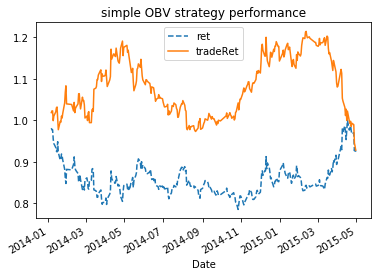

In [12]:
ret=smOBVtrade.ret
ret.name='BuyAndHold'
smtradeRet=smOBVtrade.tradeRet
smtradeRet.name='smOBVTrade'
(1+ret).cumprod().plot(label='ret',linestyle='dashed')
(1+tradeRet).cumprod().plot(label='tradeRet')
plt.title('simple OBV strategy performance')
plt.legend()

In [13]:
test=backtest(ret,smtradeRet)
test

,BuyAndHold,smOBVTrade
win rate,0.496815,0.512739
annualized return,-0.058270,0.060095
sharpe ratio,-0.010179,0.023843
maximum drawdown,-0.199358,-0.160496


In [ ]:
# we should combine OBVs and stock prices